# Improving our fit!!!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from mlxtend.evaluate import bias_variance_decomp

### Creating some data

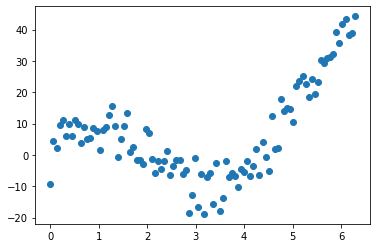

In [2]:
x = np.linspace(0,2*np.pi,100)
y = 5*x*np.cos(x) + .5*x + 5 + np.random.normal(0,5,100)
plt.scatter(x,y)

In [45]:
# Separate train and test
X_train, X_test, y_train, y_test = train_test_split(x,y)

### Let's fit some polynomial models

In [46]:
def fit_poly(X,y,k):
    # Transforms our data to allow for Polynomial regression (Matrix from last class)
    poly = PolynomialFeatures(k)
    X = poly.fit_transform(X.reshape(-1,1))
    # Linear Regression Model
    lr = LinearRegression()
    lr.fit(X,y)
    return lr

In [47]:
lr = fit_poly(X_train,y_train,2)

In [48]:
lr.coef_

array([  0.        , -21.72517007,   4.00871503])

In [49]:
lr.intercept_

22.201881083422194

In [50]:
b0,b1,b2 = lr.coef_

In [51]:
b0 = lr.intercept_

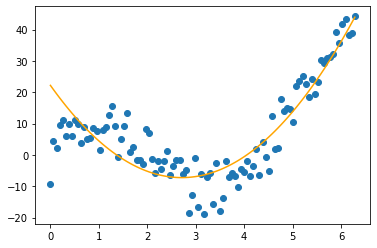

In [52]:
lr_func = lambda x: b0*x**0 + b1*x**1 + b2*x**2
plt.scatter(x,y)
plt.plot(x, lr_func(x),c="orange");

In [56]:
errors = pd.DataFrame(columns=["mse_train","mse_test","coef"])
for k in range(1,30):
    # Fit transform X_train to Polynomial form.
    poly = PolynomialFeatures(k)
    X_poly = poly.fit_transform(X_train.reshape(-1,1))
    
    # Train Model
    lr = fit_poly(X_train,y_train,k)
    coef = lr.coef_
    
    # Calculate train error
    mse_train = mean_squared_error(y_train,lr.predict(X_poly))
    
    # Transform X_test to Polynomial form
    X_poly = poly.transform(X_test.reshape(-1,1))
    
    # Calculate test error
    mse_test = mean_squared_error(y_test,lr.predict(X_poly))
    
    # Store results
    errors = errors.append(pd.Series({"mse_train":mse_train,"mse_test":mse_test,"coef":coef}, name=k))

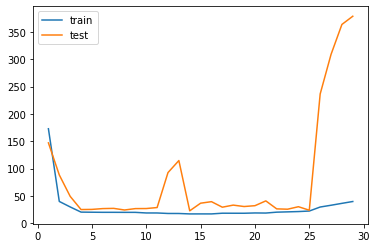

In [57]:
plt.plot(errors["mse_train"], label="train")
plt.plot(errors["mse_test"], label="test")
plt.legend();

In [58]:
errors.head()

,mse_train,mse_test,coef
1,172.783271,146.945016,"[0.0, 4.2081727025863]"
2,39.902689,88.363483,"[0.0, -21.725170074575562, 4.008715034612574]"
3,29.884429,49.255791,"[0.0, -4.423267533890326, -2.719372253685774, ..."
4,20.412646,25.106657,"[0.0, 29.00089728897026, -25.666288119845852, ..."
5,20.200086,25.358698,"[0.0, 19.684918608445624, -15.899453699247534,..."


## Ridge Regression and LASSO explained
$\beta_0$ does not count for the cost function!

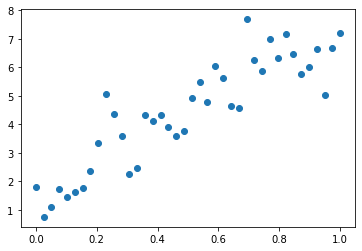

In [67]:
x = np.linspace(0,1,40)
y = 2+5*x + np.random.normal(0,1,40)
plt.scatter(x,y);

### Ridge Regression

$J(\theta) = MSE(\theta) + \alpha\beta^2$

In [77]:
cost_functions = {}
slopes = np.linspace(-5,10,100)
for alpha in [0,1,5,10,50,100,200]:
    cost_functions[alpha] = [sum((y-(2+m*x))**2) + alpha*(m**2) for m in slopes]

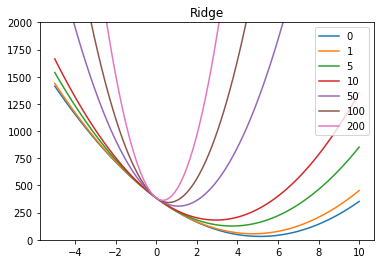

In [76]:
for k,v in cost_functions.items():
    plt.plot(slopes,v,label=k)
plt.legend()
plt.ylim(0,2000)
plt.title("Ridge");

## LASSO

$J(\theta) = MSE(\theta) + \alpha|\beta|$

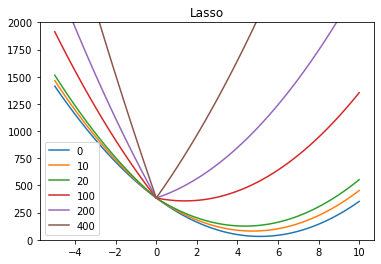

In [79]:
cost_functions = {}
slopes = np.linspace(-5,10,100)
for alpha in [0,10,20,100,200,400]:
    cost_functions[alpha] = [sum((y-(2+m*x))**2) + alpha*abs(m) for m in slopes]
for k,v in cost_functions.items():
    plt.plot(slopes,v,label=k)
plt.legend()
plt.ylim(0,2000)
plt.title("Lasso");

### Boston Housing

In [80]:
from sklearn.datasets import load_boston
X,y = load_boston(return_X_y=True)
col_names = load_boston()["feature_names"]
df = pd.DataFrame(X, columns=col_names)
df["MEDV"] = y

In [81]:
# Feature Cross
columns = df.columns[:-1]
for i in range(len(columns)):
    for j in range(i,len(columns)):
        col1 = columns[i]
        col2 = columns[j]
        df[f"{col1}*{col2}"] = df[col1]*df[col2]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["MEDV"]), df["MEDV"])

In [83]:
lr = LinearRegression()
## ALL COLUMNS + SYNTHETIC
lr.fit(X_train, y_train)
mse_train = mean_squared_error(y_train, lr.predict(X_train))
mse_test = mean_squared_error(y_test, lr.predict(X_test))
print("-"*35)
print("Linear Regression")
print(f"MSE_train: {mse_train}")
print(f"MSE_test: {mse_test}")
print("-"*35)

-----------------------------------
Linear Regression
MSE_train: 5.713784990653644
MSE_test: 12.94768801707344
-----------------------------------


In [96]:
errors = pd.DataFrame(columns=["Ridge_train","Ridge_test","LASSO_train","LASSO_test"])

In [97]:
alphas = [0,1,5,10,50,100]
coef = {}
for alpha in alphas:
    #Ridge
    ridge = Ridge(alpha=alpha,max_iter=100000)
    ridge.fit(X_train,y_train)
    ridge_train = mean_squared_error(y_train,ridge.predict(X_train))
    ridge_test = mean_squared_error(y_test,ridge.predict(X_test))
    
    #LASSO
    lasso = Lasso(alpha=alpha,max_iter=10000)
    lasso.fit(X_train,y_train)
    lasso_train = mean_squared_error(y_train,lasso.predict(X_train))
    lasso_test = mean_squared_error(y_test,lasso.predict(X_test))
    coef[alpha] = lasso.coef_
    
    errors = errors.append(pd.Series({
        "Ridge_train":ridge_train,
        "Ridge_test":ridge_test,
        "LASSO_train":lasso_train,
        "LASSO_test":lasso_test
    },name=alpha))

<ipython-input-97-3a4bbdf825e5>:12: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lasso.fit(X_train,y_train)
/home/felipe/miniconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/home/felipe/miniconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1156.9597943615074, tolerance: 3.2078868812664907
  model = cd_fast.enet_coordinate_descent(
/home/felipe/miniconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 

In [98]:
errors

,Ridge_train,Ridge_test,LASSO_train,LASSO_test
0,5.729596,13.003530,6.105329,11.165416
1,6.323930,12.478205,9.954057,12.349828
5,6.784287,11.940565,11.706567,14.380902
10,7.041903,12.072752,12.331224,14.813286
50,7.613411,12.981341,14.689758,15.876316
100,7.799893,13.103426,18.237639,17.841657


In [101]:
coef.keys()

dict_keys([0, 1, 5, 10, 50, 100])

In [102]:
coef[5]

array([ 0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -4.55339733e-04,  0.00000000e+00,
        4.29429965e-04, -0.00000000e+00,  8.86699542e-04,  0.00000000e+00,
        0.00000000e+00, -0.00000000e+00,  4.68871881e-03,  5.59715806e-04,
       -0.00000000e+00, -0.00000000e+00,  2.70227927e-04,  4.30785831e-03,
       -6.63203099e-04, -1.96683340e-03,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  6.03556842e-03, -0.00000000e+00,
        0.00000000e+00,  7.49638911e-04, -0.00000000e+00, -1.53119860e-03,
       -1.27057843e-02,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  

In [103]:
feat = [ i for i,e in enumerate(coef[10]) if e != 0]

In [105]:
X_train.shape

(379, 104)

In [106]:
len(feat)

30

In [107]:
features = X_train.iloc[:,feat].columns

In [109]:
lr = LinearRegression()
## Features selected with Lasso
lr.fit(X_train[features], y_train)
mse_train = mean_squared_error(y_train, lr.predict(X_train[features]))
mse_test = mean_squared_error(y_test, lr.predict(X_test[features]))
print("-"*35)
print("Linear Regression")
print(f"MSE_train: {mse_train}")
print(f"MSE_test: {mse_test}")
print("-"*35)

-----------------------------------
Linear Regression
MSE_train: 11.916115776807949
MSE_test: 14.530256782669282
-----------------------------------


In [110]:
features

Index(['CRIM*TAX', 'CRIM*B', 'ZN*ZN', 'ZN*TAX', 'ZN*PTRATIO', 'ZN*B',
       'INDUS*AGE', 'INDUS*TAX', 'INDUS*B', 'CHAS*B', 'NOX*TAX', 'RM*TAX',
       'RM*B', 'AGE*AGE', 'AGE*RAD', 'AGE*TAX', 'AGE*PTRATIO', 'AGE*B',
       'AGE*LSTAT', 'DIS*TAX', 'DIS*B', 'RAD*B', 'TAX*TAX', 'TAX*PTRATIO',
       'TAX*B', 'TAX*LSTAT', 'PTRATIO*B', 'B*B', 'B*LSTAT', 'LSTAT*LSTAT'],
      dtype='object')

In [111]:
14.530256782669282**.5

3.811857392750847

In [113]:
print(load_boston()["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

# The best of Both Worlds

# ElasticNet